In [92]:
# Fr
file_path = './gmusic_activity.json'
review_year = 2019

In [93]:
import json

data = ''
with open(file_path) as f:
    data = f.read()
data = json.loads(data)

## What keys we got??

In [94]:
keys = set()
for d in data:
    keys.update(d.keys())
print(keys)

{'header', 'description', 'subtitles', 'time', 'products', 'titleUrl', 'title'}


## GONNA DEFINE STUFF HERE

In [95]:
from collections import Counter, defaultdict
from datetime import datetime, time

ACTIVITY_LISTEN_PREFIX = 'Listen'
ACTIVITY_SKIP_PREFIX = 'Skip'
ACTIVITY_SEARCH_PREFIX = 'Search'
ACTIVITY_USE_PREFIX = 'Use'
ACTIVITY_TYPES = [ACTIVITY_LISTEN_PREFIX, ACTIVITY_SKIP_PREFIX, ACTIVITY_SEARCH_PREFIX, ACTIVITY_USE_PREFIX]

SUBTITLE_ACTIVITY = 'Activity'
SUBTITLE_LOCATION = 'Location'
SUBTITLE_TEMPERATURE = 'Temperature'
SUBTITLE_WEATHER = 'Weather'
SUBTITLE_SUN = 'Sun'

class GoogleMusicActivity:
    def __init__(self, **kwargs):
        self.description = kwargs.get('description', '')
        self.header = kwargs.get('header', '')
        self.products = kwargs.get('products', '')
        self.title = kwargs.get('title', '')
        self.url = kwargs.get('titleUrl', '')
        
        self._init_subtitles(kwargs.get('subtitles', ''))
        time_str = kwargs.get('time', '').rstrip('Z')
        if time_str:
            self.time = datetime.fromisoformat(time_str)
        else:
            self.time = time()
    
    def __repr__(self):
        return str(self.__dict__)
    
    def _init_subtitles(self, subtitles):
        self.subtitles = defaultdict(list)
        for s in subtitles:
            sub = s['name'].split(':')
            if len(sub) < 2:
                continue
            sub_attr = sub[0].strip()
            sub_val = sub[1].strip()
            self.subtitles[sub_attr].append(sub_val)            
            
    def get_action(self):
        for a in ACTIVITY_TYPES:
            if self.title.startswith(a):
                return a
        
        return self.title

    def get_activities(self):
        return self.subtitles[SUBTITLE_ACTIVITY]
    
    def get_locations(self):
        return self.subtitles[SUBTITLE_LOCATION]
    
    def get_weather(self):
        return self.subtitles[SUBTITLE_WEATHER]
    
    def get_temperature(self):
        return self.subtitles[SUBTITLE_TEMPERATURE]
    
    def get_sun(self):
        return self.subtitles[SUBTITLE_SUN]

In [96]:
activities = []
for d in data:
    activities.append(GoogleMusicActivity(**d))

## What actions we got??

In [97]:
action_counter = Counter()
for a in activities:
    action_counter[a.get_action()] += 1
print(action_counter)

Counter({'Listen': 70146, 'Skip': 26970, 'Use': 1000, 'Search': 398})


## Filter dem actions

In [98]:
print(f'Filtering {len(activities)} actions...')
activities = [a for a in activities if a.time.year == review_year]
activities = [a for a in activities if a.get_action() == ACTIVITY_LISTEN_PREFIX]
print(f'Ended up with {len(activities)} actions')

Filtering 98514 actions...
Ended up with 24235 actions


## What subtitles we got??

In [99]:
keys = set()
for d in data:
    if not 'subtitles' in d:
        continue
    for s in d['subtitles']:
        keys.update(s.keys())
print(keys)

{'name'}


In [100]:
subtitles = Counter()
for d in data:
    if not 'subtitles' in d:
        continue
    for s in d['subtitles']:
        subtitles[s['name']] += 1
subtitles

Counter({'Served location and activity-based recommendations': 7819,
         'Location: Airport': 36,
         'Activity: Leisure': 7161,
         'Activity: Traveling': 26,
         'Activity: Standing still': 6160,
         'Activity: In flight': 36,
         'Temperature: Cool': 6141,
         'Weather: Overcast': 5144,
         'Temperature: Warm': 8899,
         'Weather: Clear': 7806,
         'Location: Bar': 102,
         'Activity: On foot': 198,
         'Weather: Rain': 110,
         'Activity: Eating': 71,
         'Served location-based recommendations': 7221,
         'Weather: Partly cloudy': 1937,
         'Sun: Sunset': 995,
         'Activity: Commuting': 207,
         'Activity: In a vehicle': 37,
         'Location: School': 5,
         'Location: Mall': 4,
         'Activity: Shopping': 4,
         'Location: Transit station': 69})

In [101]:
import matplotlib.pyplot as plt

def plot_counter(counter, title=''):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xticks(rotation=45)
    
    sorted_counter = counter.most_common()
    x = [v[0] for v in sorted_counter]
    y = [v[1] for v in sorted_counter]
    plt.bar(x, y)

Activity histogram for 24235 data points


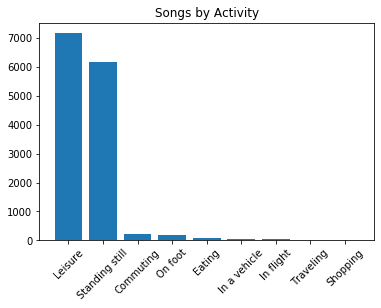

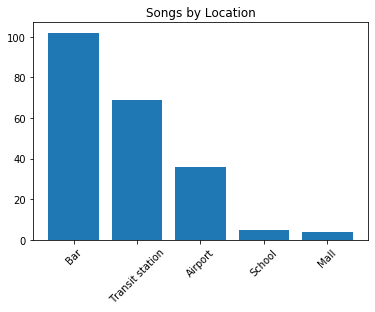

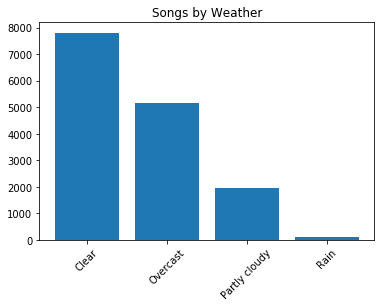

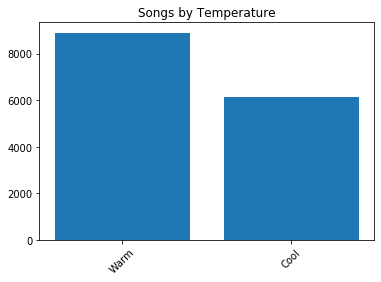

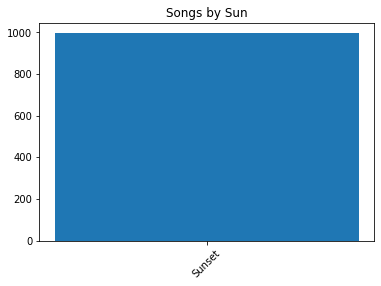

In [102]:
activity_counter = Counter()
location_counter = Counter()
weather_counter = Counter()
temp_counter = Counter()
sun_counter = Counter()
for a in activities:
    for ac in a.get_activities():
        activity_counter[ac] += 1
    for l in a.get_locations():
        location_counter[l] += 1
    for w in a.get_weather():
        weather_counter[w] += 1
    for t in a.get_temperature():
        temp_counter[t] += 1
    for s in a.get_sun():
        sun_counter[s] += 1

plot_counter(activity_counter, title='Songs by Activity')
plot_counter(location_counter, title='Songs by Location')
plot_counter(weather_counter, title='Songs by Weather')
plot_counter(temp_counter, title='Songs by Temperature')
plot_counter(sun_counter, title='Songs by Sun')
print(f'Activity histogram for {len(activities)} data points')

In [103]:
## TODO: Top genres/artists, playtime, etc